In [1]:
import pandas as pd
#from sklearn.preprocessing import Imputer
#from sklearn.impute import SimpleImputer
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from stldecompose import decompose
import time
from functools import reduce
from functools import partial
import tensorflow as tf
from datetime import datetime
import random
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import timedelta
from random import shuffle
from scipy import sparse
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout
from tensorflow.python.keras.optimizers import RMSprop , Adam, SGD
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import TimeDistributed, Activation, RepeatVector, BatchNormalization
ip=get_ipython()
user_ns=ip.user_ns
import_ls=%who_ls

c:\users\md38\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\md38\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\md38\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\md38\appdata\

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4781658231152063013
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 20309735506
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12050169929728204374
physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:2d:00.0, compute capability: 7.5"
]


In [3]:
import nvidia_smi
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

res = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
print(f'gpu: {res.gpu}%, gpu-mem: {res.memory}%')

gpu: 5%, gpu-mem: 0%


In [4]:
def lookup(s):
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)
file_ls=['daily_spx.csv','daily_INTC.csv','daily_amzn.csv','daily_aapl.csv','daily_msft.csv','daily_amd.csv']
s=1000
df=pd.DataFrame(columns=['StoreNumber','DateTime','Open','High','Low','Close','Volume'])
for file in file_ls:
    s+=1
    df_temp=pd.read_csv(file)
    df_temp.columns=['DateTime','Open','High','Low','Close','Volume']
    df_temp['DateTime']=lookup(df_temp['DateTime'])
    df_temp['StoreNumber']=s
    df_temp=df_temp[['StoreNumber','DateTime','Open','High','Low','Close','Volume']]
    df=pd.concat([df,df_temp])
del df_temp

In [5]:
#df_new['Hour'] = df_new['DateTime'].dt.hour
df['Weekday'] = df['DateTime'].dt.weekday
df['Monthday'] =df['DateTime'].dt.day
cal = calendar()
#df_new=df_new.sort_values(['StoreNumber','DateTime']).reset_index()
holidays=cal.holidays(df.DateTime.min(), end=df.DateTime.max())
holidays=[i.date() for i in holidays]
df.loc[df['DateTime'].dt.date.isin(holidays),'Holidays']=2

holidays=cal.holidays(df.DateTime.min(), end=df.DateTime.max())- timedelta(days=1)
holidays=[i.date() for i in holidays]
df.loc[df['DateTime'].dt.date.isin(holidays),'Holidays']=1

holidays=cal.holidays(df.DateTime.min(), end=df.DateTime.max())+ timedelta(days=1)
holidays=[i.date() for i in holidays]
df.loc[df['DateTime'].dt.date.isin(holidays),'Holidays']=3
df.loc[df['Holidays'].isnull(),'Holidays']=0
# add total sales as an indicator of the store scale
#df['StoreScale']=df.groupby('StoreNumber')['Gallons'].transform(lambda x: x.interpolate().sum()/x.interpolate().count())

In [6]:
var_ls=%who_ls
set(var_ls)-set(import_ls)

{'cal',
 'device_lib',
 'df',
 'file',
 'file_ls',
 'handle',
 'holidays',
 'import_ls',
 'lookup',
 'nvidia_smi',
 'res',
 's'}

In [7]:
del cal,holidays,var_ls

In [8]:
df.groupby('StoreNumber')['DateTime'].min()

StoreNumber
1001   2000-01-03
1002   1999-11-19
1003   1999-11-19
1004   1999-11-19
1005   1999-11-19
1006   1999-11-19
Name: DateTime, dtype: datetime64[ns]

In [9]:
#keep healthy cycle data (extreme)
df=df[df['DateTime']>=datetime.strptime('2000-01-03 00:00:00' , '%Y-%m-%d %H:%M:%S')]
df=df.sort_values(['StoreNumber','DateTime']).reset_index(drop=True)
df['Diff']=df['Close']-df['Open']

In [10]:
df.columns

Index(['StoreNumber', 'DateTime', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Weekday', 'Monthday', 'Holidays', 'Diff'],
      dtype='object')

In [11]:
df['Holidays']=df['Holidays'].astype(int)

In [12]:
#df_new.to_pickle('df_new_model_ready')
#df_new=pd.read_pickle('df_new_model_ready')

In [13]:
cat_columns=['Weekday','Monthday','Holidays', ]
prev_columns=list(df.columns)
prev_columns.remove('StoreNumber')
prev_columns.remove('DateTime')
target_names=['Open']
unknowns=['High', 'Low', 'Close', 'Volume','Diff']
knowns=list(df.columns)
for col in unknowns:
    knowns.remove(col)

shift_days = 1
shift_steps = shift_days * 1  # Number of hours.

#df_targets = df_new.groupby('StoreNumber')[target_names].shift(-shift_steps).dropna().copy()
#x_data_present=df_new[knowns][shift_steps:].copy()

df_present=df.groupby('StoreNumber')[knowns].transform(lambda x: x.shift(-shift_steps)).dropna().copy()
df_present.reset_index(drop=True, inplace=True)
#x_data_df[['Hour']]=x_data_df[['Hour']].apply(lambda x: np.sin(2.0*np.pi*(x+0.5)/24.0)+np.cos(2.0*np.pi*(x+0.5)/24.0))
#x_data_df[['Weekday']]=x_data_df[['Weekday']].apply(lambda x: np.sin(2.0*np.pi*(x-0.5)/7.0)+np.cos(2.0*np.pi*(x-0.5)/7.0))
#x_data_df=pd.get_dummies(x_data_df, columns=['Hour', 'Weekday'])
df_previous=df.groupby('StoreNumber')[prev_columns].transform(lambda x: x.shift(shift_steps)).dropna().copy()
df_previous.reset_index(drop=True, inplace=True)
df_previous.columns=[s + '_prev' for s in df_previous.columns]

df=pd.concat([df_present,df_previous],axis=1)
#y_data = df_targets.values[:-shift_steps]

In [14]:
df.columns

Index(['StoreNumber', 'DateTime', 'Open', 'Weekday', 'Monthday', 'Holidays',
       'Open_prev', 'High_prev', 'Low_prev', 'Close_prev', 'Volume_prev',
       'Weekday_prev', 'Monthday_prev', 'Holidays_prev', 'Diff_prev'],
      dtype='object')

In [15]:
#df.to_pickle('df_model_ready')
#df=pd.read_pickle('df_model_ready')

In [16]:
var_ls=%who_ls
set(var_ls)-set(import_ls)

{'cat_columns',
 'col',
 'device_lib',
 'df',
 'df_present',
 'df_previous',
 'file',
 'file_ls',
 'handle',
 'import_ls',
 'knowns',
 'lookup',
 'nvidia_smi',
 'prev_columns',
 'res',
 's',
 'shift_days',
 'shift_steps',
 'target_names',
 'unknowns'}

In [17]:
del df_present,df_previous,var_ls

In [18]:
cat_columns.extend([s + '_prev' for s in prev_columns if s in cat_columns])
df=pd.get_dummies(df,columns=cat_columns)

In [19]:
target_names=['Open']
num_data = len(df)
x_cols=['Open_prev','Diff_prev']
#x_cols=list(set(df.columns)-set(['StoreNumber','DateTime'])-set(target_names))
store_val_cols=[ 'Open_prev',
 'High_prev',
 'Low_prev',
 'Close_prev','Volume_prev','Diff_prev']
store_val_cols=[s for s in store_val_cols if s in x_cols]
val_cols=[ ]
store_ls=list(df.StoreNumber.drop_duplicates())
store_ls=[int(i) for i in store_ls]


In [20]:
x_scaled=df[['StoreNumber','DateTime']+x_cols].copy()
y_scaled=df[['StoreNumber','DateTime']+target_names].copy()
x_scaler={}
y_scaler={}
#x_scaler[0] = MinMaxScaler()
#x_scaled[val_cols]=x_scaler[0].fit_transform(x_scaled[val_cols])
for store in store_ls:
    x_scaler[store] = MinMaxScaler()#StandardScaler()
    x_scaled.loc[x_scaled["StoreNumber"]==store,store_val_cols] = \
    x_scaler[store].fit_transform(df[df["StoreNumber"]==store][store_val_cols])
    y_scaler[store] = MinMaxScaler()
    y_scaled.loc[df["StoreNumber"]==store,target_names] = \
    y_scaler[store].fit_transform(df[df["StoreNumber"]==store][target_names]\
    .values.reshape(-1, 1)).reshape(1, -1)[0]
#np.save('x_train_scaled.npy',x_train_scaled)
#np.save('y_train_scaled.npy',y_train_scaled)
#np.save('x_test_scaled.npy',x_test_scaled)
#np.save('y_test_scaled.npy',y_test_scaled)

In [21]:
train_split = 0.85
datetime_length=df.DateTime.drop_duplicates().count()
n_steps=df.StoreNumber.drop_duplicates().count()
num_train = int(train_split * datetime_length)
num_test = datetime_length - num_train
x_train = x_scaled.groupby('StoreNumber')[x_scaled.columns].apply(lambda x: x[0:num_train]).reset_index(drop=True)
x_test = x_scaled.groupby('StoreNumber')[x_scaled.columns].apply(lambda x: x[num_train:]).reset_index(drop=True)
y_train = y_scaled.groupby('StoreNumber')[y_scaled.columns].apply(lambda x: x[0:num_train]).reset_index(drop=True)
y_test = y_scaled.groupby('StoreNumber')[y_scaled.columns].apply(lambda x: x[num_train:]).reset_index(drop=True)
#num_x_signals = x_data.shape[1]
#num_y_signals = y_data.shape[1]

In [22]:
arr_x_train=sparse.csr_matrix(x_train.values[:,2:].astype(float))
arr_y_train=y_train.values
arr_x_test=sparse.csr_matrix(x_test.values[:,2:].astype(float))
arr_y_test=y_test.values
#sparse.save_npz('arr_x_train.npz', arr_x_train)
#np.save('arr_y_train.npy',arr_y_train, allow_pickle=True)
#sparse.save_npz('arr_x_test.npz', arr_x_test)
#np.save('arr_y_test.npy',arr_y_test, allow_pickle=True)

In [23]:
#arr_x_train = sparse.load_npz('arr_x_train.npz')
#arr_y_train = np.load('arr_y_train.npy', allow_pickle=True)
#arr_x_test = sparse.load_npz('arr_x_test.npz')
#arr_y_test = np.load('arr_y_test.npy', allow_pickle=True)

In [24]:
store_ls=np.unique(arr_y_train[:,0])
n_steps=len(store_ls)
store_ls=[int(i) for i in store_ls]
num_x_signals = arr_x_train.shape[1]
num_y_signals = arr_y_train.shape[1]-2
num_test=arr_y_test[arr_y_test[:,0]==1001].shape[0]
x_shape= (len(store_ls), num_test, num_x_signals)
x_val = np.zeros(shape=x_shape, dtype=np.float16)
y_shape= (len(store_ls), num_test, num_y_signals)
y_val = np.zeros(shape=y_shape, dtype=np.float16)
i=0
for store in store_ls:
    cond=arr_y_test[:,0]==store
    x_val[i] = arr_x_test[cond,:].toarray()
    y_val[i] = arr_y_test[cond,2:]
    i+=1
validation_data = (x_val,y_val)

In [25]:
n_epochs=40
sequence_length = 24 * 7 * 3
#sequence_length=24 * 7 * 8
stride=24

datetime_train_length=arr_y_train[arr_y_train[:,0]==1001].shape[0]
batch_size=math.ceil((datetime_train_length-sequence_length)/stride+1) #125
batch_store_max=math.ceil((datetime_train_length-sequence_length)/stride+1)
n_batchs=math.ceil(batch_store_max/batch_size)
n_batch_steps=n_batchs*n_steps
batch_length=sequence_length+stride*(batch_size-1)

def fill_stores(n):
    store_random_dic = {}
    store_random_ls=np.unique(arr_y_train[:,0])
    store_random_ls=[int(i) for i in store_random_ls]
    shuffle(store_random_ls)
    for rand_store in store_random_ls:
        store_random_dic[rand_store]=list(range(n))
        shuffle(store_random_dic[rand_store])
    return store_random_ls,store_random_dic

def make_rand_store(sequence_length, batch_size,n_epochs, stride):
    if batch_store_max<batch_size: return print('batch size is greater than max batch size')
    rand_vars=np.zeros((n_batch_steps*n_epochs,2), dtype=np.int32)
    store_random_ls=[]
    for i in range(n_batch_steps*n_epochs):
        if store_random_ls==[]:
            store_random_ls,store_random_dic=fill_stores(n_batchs)
        rand_store = random.choice(store_random_ls)
        n_batch = random.choice(store_random_dic[rand_store])
        store_random_dic[rand_store].remove(n_batch)
        if store_random_dic[rand_store]==[]:
            store_random_ls.remove(rand_store)
        rand_vars[i]=[rand_store,n_batch]
    return rand_vars
rand_vars=make_rand_store(sequence_length, batch_size,n_epochs, stride)

In [26]:
def storedata_generator2(sequence_length, batch_size, stride=24):
    """
    Generator function for creating random batches of training-data.
    """
    # infinite loop.
    store_random_ls=[]
    
    # Allocate a new array for the batch of input-signals.
    x_shape = (batch_size, sequence_length, num_x_signals)
    x_batch = np.zeros(shape=x_shape, dtype=np.float16)

    # Allocate a new array for the batch of output-signals.
    y_shape = (batch_size, sequence_length, num_y_signals)
    y_batch = np.zeros(shape=y_shape, dtype=np.float16)
    s=0
    while True:
        rand_store,n_batch=rand_vars[s]
        cond=arr_y_train[:,0]==rand_store
        x_store=arr_x_train[cond,:].toarray()
        y_store=arr_y_train[cond,2:]
        for i in range(batch_size):
            if (n_batch != n_batchs-1)&(n_batchs != 1):
                start = (n_batch*batch_size+i)*stride
            elif (n_batchs == 1):
                if i != batch_size-1:
                    start = i*stride
                else:
                    start =  datetime_train_length-sequence_length                    
            else:
                start = datetime_train_length - batch_length + stride*i
            end = start + sequence_length        
            x_batch[i] = x_store[start:end]
            y_batch[i] = y_store[start:end]
        s+=1
        yield (x_batch, y_batch)

In [27]:
%%time
generator = storedata_generator2(sequence_length,batch_size,stride)
x_batch, y_batch = next(generator)

Wall time: 5.97 ms


In [28]:
%timeit -n 10 x_batch, y_batch = next(generator)

3.22 ms ± 620 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
generator = storedata_generator2(sequence_length,batch_size,
                           stride)
#generator = TimeseriesGenerator(x_train_scaled, y_train_scaled, length=3, batch_size=2,sampling_rate=4)
#x_batch, y_batch = next(generator)
#batch = 0   # First sequence in the batch.
#signal = 0  # First signal from the 20 input-signals.


In [30]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [31]:
#model1
model = Sequential()
#model.add(GRU(units=512,
model.add(LSTM(units=512,
              #dropout=0.0, recurrent_dropout=0.0,
              #kernel_initializer=keras.initializers.RandomNormal(seed=1337),
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
#model.add(Dropout(0.4))
model.add(LSTM(256, dropout=0.0
               ,return_sequences=True,
               #kernel_initializer=keras.initializers.RandomNormal(seed=1337),
              ))
model.add(LSTM(128, dropout=0.0
               ,return_sequences=True
               #kernel_initializer=keras.initializers.RandomNormal(seed=1337),
              ))
model.add(Dense(num_y_signals, activation='sigmoid'))
"""
if False:
    from tensorflow.python.keras.initializers import RandomUniform
    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))
"""
warmup_steps = 50
#optimizer = RMSprop(lr=1e-3)
optimizer = Adam(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 512)         1054720   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 256)         787456    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
dense (Dense)                (None, None, 1)           129       
Total params: 2,039,425
Trainable params: 2,039,425
Non-trainable params: 0
_________________________________________________________________


In [31]:
path_checkpoint = 'checkpoint_test_future.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=2,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [32]:
%%time
#model 4
#load best!
history = model.fit_generator(generator=generator,
                    epochs=n_epochs,
                    verbose=1,
                    shuffle=False,
                    steps_per_epoch=n_batch_steps,
                    validation_data=validation_data,
                    callbacks=callbacks)
#score, acc = model.evaluate(validation_data)
#print('Test score:', score)
#print('Test accuracy:', acc)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: name 'model' is not defined

In [73]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [74]:
result = model.evaluate(x=x_val,
                        y=y_val)

6/6 [==============================] - 1s 154ms/sample - loss: 0.1413


In [26]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        pripred,x,y_turent("{0}: {1:.3e}".format(metric, res))

In [103]:
DateTime=np.array(df['DateTime'].drop_duplicates())
def plot_comparison_store(store, start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x=arr_x_train[arr_y_train[:,0]==store,:].toarray()
        time_range=DateTime[:num_train ]
        y_true = arr_y_train[arr_y_train[:,0]==store,2:]
    else:
        # Use test-data.
        x=arr_x_test[arr_y_test[:,0]==store,:].toarray()
        time_range=DateTime[:num_train ]
        y_true = arr_y_test[arr_y_test[:,0]==store,2:]
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    time_range=time_range[start_idx:end_idx]
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    print(y_pred[0].shape)
    y_pred_rescaled = y_scaler[store].inverse_transform(y_pred[0])
    #y_pred_rescaled = y_pred[0]
    y_true=y_scaler[store].inverse_transform(y_true)
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(time_range,signal_true, label='true')
        plt.plot(time_range,signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(time_range[0], time_range[warmup_steps], facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [111]:
DateTime=np.array(df['DateTime'].drop_duplicates())
def plot_comparison_store(store, start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x=arr_x_train[arr_y_train[:,0]==store,:].toarray()
        time_range=DateTime[:num_train ]
        y_true = arr_y_train[arr_y_train[:,0]==store,2:]
    else:
        # Use test-data.
        x=arr_x_test[arr_y_test[:,0]==store,:].toarray()
        time_range=DateTime[:num_train ]
        y_true = arr_y_test[arr_y_test[:,0]==store,2:]
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    time_range=time_range[start_idx:end_idx]
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    print(y_pred[0].shape)
    y_pred_rescaled = y_scaler[store].inverse_transform(y_pred[0])
    #y_pred_rescaled = y_pred[0]
    y_true=y_scaler[store].inverse_transform(y_true)
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(time_range,signal_true, label='true')
        plt.plot(time_range,signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(time_range[0], time_range[warmup_steps], facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [112]:
store_ls

[1001, 1002, 1003, 1004, 1005, 1006]

(500, 1)


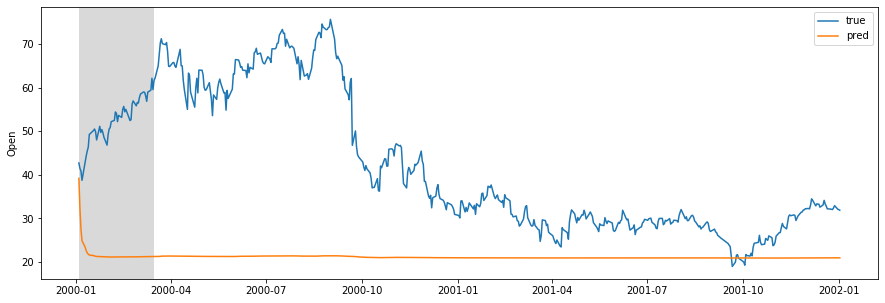

In [124]:
#current
plot_comparison_store(1002, 0, length=500, train=True)